#### Clear Ram

In [1]:
import gc

In [2]:
gc.collect()

0

#### Load Libraries

In [3]:

import pickle
from utils import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler

random.seed(444)

### Load & Process Data

#### Define Data Paths

In [4]:
main_path = '[path_to_datafolder]'
main_path_wavelet = '[path_to_datafolder]/scallogramTest/gaus1/'

ab_edf_path = main_path + 'edf/Abnormal EDF Files/'
n_edf_path = main_path + 'edf/Normal EDF Files/'
ab_labels_path = main_path + 'csv/SW & SSW CSV Files/'
save_path = main_path + 'data_chunks/'

In [5]:
class_label_names = ['normal', 'slowing', 'spike and wave']

#### Load Data from File

In [6]:
all_edf_data = np.concatenate((os.listdir(n_edf_path),os.listdir(ab_edf_path)), axis = 0)

In [7]:
# Line position for train and test

train_pos = 0
valid_pos = 381134
test_pos = 448393

In [8]:
def getCwt(data,channel,rawData,waveletType):
    scales = np.arange(1,24) 
    sig_cwt,_ = pywt.cwt(data, scales , waveletType,method = 'fft')

    feature_vector = []
    for k in range(len(sig_cwt)):
        feature_vector.append(stat_features(sig_cwt[k]))


    fv = np.array(feature_vector).flatten()

    return fv
 

In [ ]:
mne.set_log_level('WARNING')
waveletTypes = ['mexh','morl','gaus1','gaus2']

normal_count = 0
slowing_count = 0
spike_count = 0
test_window_data = {
    'mexh':[],
    'morl':[],
    'gaus1':[],
    'gaus2':[]
}
test_window_labels = {
    'mexh':[],
    'morl':[],
    'gaus1':[],
    'gaus2':[]
}

train_window_data = {
    'mexh':[],
    'morl':[],
    'gaus1':[],
    'gaus2':[]
}
train_window_labels = {
    'mexh':[],
    'morl':[],
    'gaus1':[],
    'gaus2':[]
}


for edf_name in tqdm(all_edf_data):
    file_num = int(edf_name[:-4])
    
    if edf_name in os.listdir(ab_edf_path):
        edf_path = ab_edf_path
    else:
        edf_path = n_edf_path
    
    raw = mne.io.read_raw_edf(edf_path+edf_name,preload = True,exclude = ['A1','A2'])     # Importing all EEG Channels, exculding A1 A2 since matlab has already refrenced the channels with A1 and A2
    raw.filter(l_freq=2,h_freq=45)      # Bandpass filtering [1-45] Hz
    epochs=mne.make_fixed_length_epochs(raw,duration=2,overlap=1)
    epochs_data=epochs.get_data()
    
    rawdata = np.array(raw.get_data()[0:19])
    print('epochs_data shape = ',epochs_data.shape)

    ############### Artifact removal For Normal Windows ###################
    rawNormal = raw.copy()
    rawNormal.filter(l_freq=2,h_freq=45,verbose=False)
    montage =  mne.channels.make_standard_montage('standard_1005')
    rawNormal.set_montage(montage, match_case=False,verbose=False)
    ica = mne.preprocessing.ICA(method="picard", max_iter="auto", random_state=56,verbose=False)
    ica.fit(rawNormal,verbose=False)
    muscle_idx_auto, scores = ica.find_bads_muscle(rawNormal,verbose=False)
    badIndexes = np.where(np.array(scores) > np.median(scores)*0.5)[0].tolist()
    ica.exclude = badIndexes
    print(f"Automatically found muscle artifact ICA components: {badIndexes}")
    ica.apply(rawNormal,verbose=False)
    full_dataNormal = np.array(rawNormal.get_data(verbose=False))
    epochs2=mne.make_fixed_length_epochs(rawNormal,duration=2,overlap=1,verbose=False)
    Epochs_data_normal=epochs2.get_data(verbose=False)
    #######################################################################
    
    # Epochs_data = np.concatenate((Epochs_data, epochs_data), axis=0)

    with open(main_path_wavelet + 'window_tracker.txt', 'r') as f:
        lines = f.readlines()
        for single_line in lines[train_pos+1:valid_pos]:
            single_line_list = single_line.split(' ')
                
            if edf_name == single_line_list[0]:
                for wavelet in waveletTypes:
                    if int(single_line_list[3]) != 0:
                        data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        train_window_data[wavelet].append(pca_features)
                        train_window_labels[wavelet].append(np.array(int(single_line_list[3])))
                    else: 
                        data = Epochs_data_normal[int(single_line_list[2])][int(single_line_list[1])]
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        train_window_data[wavelet].append(pca_features)
                        train_window_labels[wavelet].append(np.array(int(single_line_list[3])))
            
        for single_line in lines[valid_pos+1:test_pos]:
            single_line_list = single_line.split(' ')

            if edf_name == single_line_list[0]:
                for wavelet in waveletTypes:
                    if int(single_line_list[3]) != 0:
                        data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        train_window_data[wavelet].append(pca_features)
                        train_window_labels[wavelet].append(np.array(int(single_line_list[3])))
                    else: 
                        data = Epochs_data_normal[int(single_line_list[2])][int(single_line_list[1])]
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        train_window_data[wavelet].append(pca_features)
                        train_window_labels[wavelet].append(np.array(int(single_line_list[3])))
        
        for single_line in lines[test_pos+1:]:
            single_line_list = single_line.split(' ')
            if edf_name == single_line_list[0]:
                
                for wavelet in waveletTypes:
                    if int(single_line_list[3]) != 0:
                        data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        test_window_data[wavelet].append(pca_features)
                        test_window_labels[wavelet].append(np.array(int(single_line_list[3])))
                    else:
                        data = Epochs_data_normal[int(single_line_list[2])][int(single_line_list[1])]
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        test_window_data[wavelet].append(pca_features)
                        test_window_labels[wavelet].append(np.array(int(single_line_list[3])))
    collected = gc.collect()
    print(type(train_window_data),len(train_window_data['mexh']))

In [11]:
with open(save_path + 'X_train.pkl', 'wb') as file:
    pickle.dump(train_window_data, file)
with open(save_path + 'Y_train.pkl', 'wb') as file:
    pickle.dump(train_window_labels, file)

with open(save_path + 'X_test.pkl', 'wb') as file:
    pickle.dump(test_window_data, file)
with open(save_path + 'Y_test.pkl', 'wb') as file:
    pickle.dump(test_window_labels, file)

In [16]:
with open(save_path + 'X_train.pkl', 'rb') as pickle_file:
    train_window_data = pickle.load(pickle_file)
with open(save_path + 'Y_train.pkl', 'rb') as pickle_file:
    train_window_labels = pickle.load(pickle_file)

with open(save_path + 'X_test.pkl', 'rb') as pickle_file:
    test_window_data = pickle.load(pickle_file)
with open(save_path + 'Y_test.pkl', 'rb') as pickle_file:
    test_window_labels = pickle.load(pickle_file)




#### Standardize Data

### Model Implementation

In [18]:
waveletTypes = ['mexh','morl','gaus1','gaus2']
scaler = {
    "mexh" : StandardScaler(),
    "morl" : StandardScaler(),
    "gaus1": StandardScaler(),
    "gaus2": StandardScaler()
}

# Training the model chunk by chunk

for wavelet in waveletTypes:
    X_train = train_window_data[wavelet]
    if len(X_train) > 0:
        scaler[wavelet].fit(X_train)  # Normalize data
        train_window_data[wavelet] = scaler[wavelet].transform(train_window_data[wavelet])
        test_window_data[wavelet] = scaler[wavelet].transform(test_window_data[wavelet])
        

In [19]:
np.shape(train_window_data['mexh'])

(448389, 115)

Number of components required to explain 99.0% variance: 13 mexh


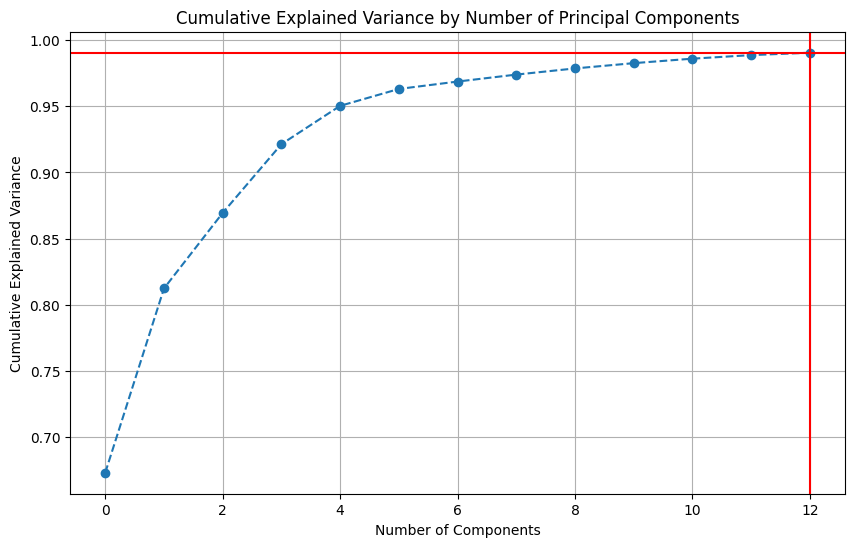

Number of components required to explain 99.0% variance: 17 morl


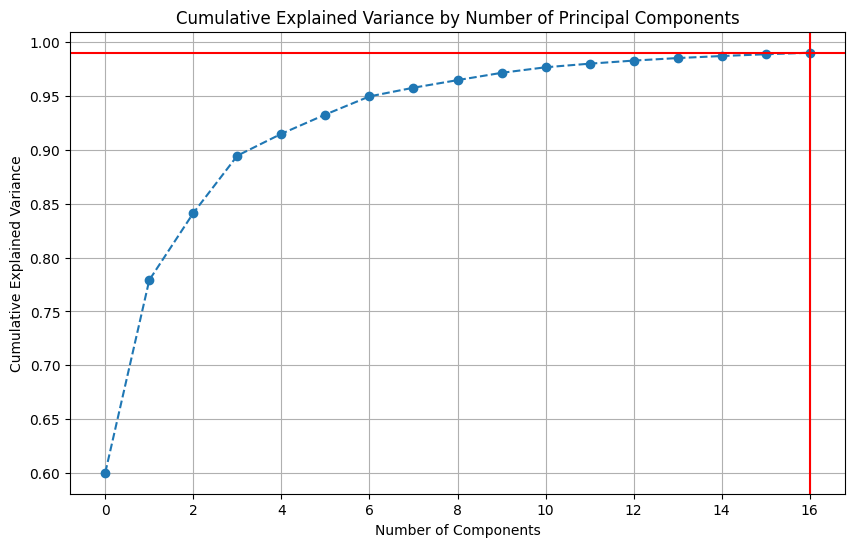

Number of components required to explain 99.0% variance: 10 gaus1


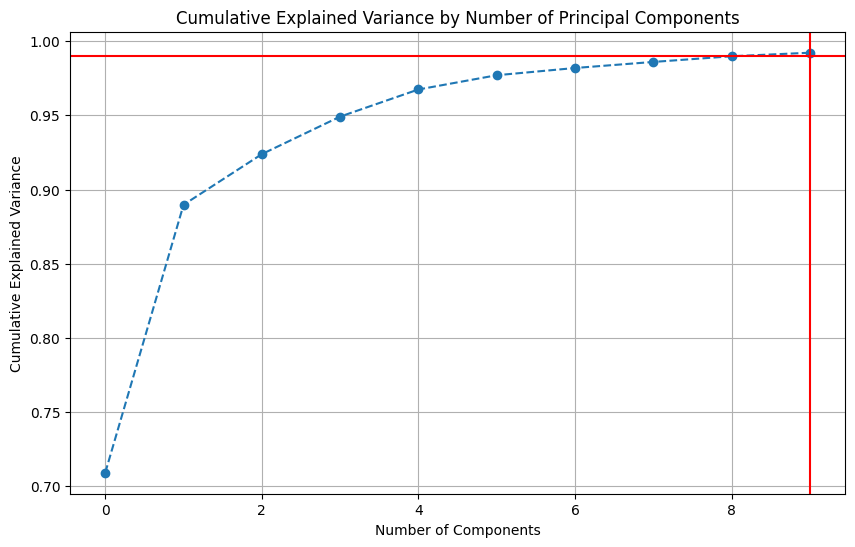

Number of components required to explain 99.0% variance: 12 gaus2


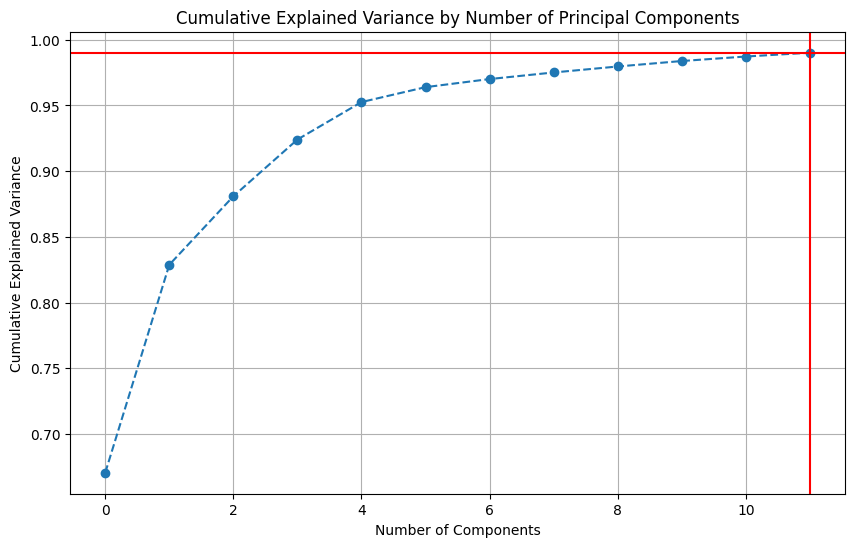

In [20]:
for wavelet in waveletTypes:
    pca = PCA(0.99)
    pca.fit(train_window_data[wavelet])
    train_window_data[wavelet] = pca.transform(train_window_data[wavelet])
    test_window_data[wavelet] = pca.transform(test_window_data[wavelet])

    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components where the cumulative explained variance meets or exceeds the threshold
    threshold = 0.99
    num_components = np.argmax(cumulative_explained_variance >= threshold) + 1

    # Print the number of components
    print(f"Number of components required to explain {threshold*100}% variance: {num_components} " + wavelet)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by Number of Principal Components')
    plt.axhline(y=threshold, color='r', linestyle='-')
    plt.axvline(x=num_components-1, color='r', linestyle='-')
    plt.grid(True)
    plt.show()

In [21]:
np.shape(test_window_data['mexh'])

(99022, 13)

In [22]:
def print_score(clf,  X_test, y_test):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''

    '''
    test performance
    '''
    print("Test Result:\n")        
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
    print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test), digits=5)))
    cm = confusion_matrix(y_test, clf.predict(X_test))
    print(cm)

In [23]:
for wavelet in waveletTypes:
    print(wavelet)
    cart_clf = DecisionTreeClassifier(criterion='entropy',max_features = 'sqrt',random_state = 0,max_depth=5,min_samples_leaf=1,splitter = 'best')
    cart_clf.fit(train_window_data[wavelet], train_window_labels[wavelet])
    print_score(cart_clf, test_window_data[wavelet], test_window_labels[wavelet])

mexh
Test Result:

accuracy score: 0.7198

Classification Report: 
               precision    recall  f1-score   support

           0    0.88962   0.86455   0.87691     50697
           1    0.58511   0.45474   0.51175     25164
           2    0.52999   0.69099   0.59987     23161

    accuracy                        0.71981     99022
   macro avg    0.66824   0.67009   0.66284     99022
weighted avg    0.72812   0.71981   0.71931     99022


[[43830  4119  2748]
 [ 2276 11443 11445]
 [ 3162  3995 16004]]
morl
Test Result:

accuracy score: 0.6542

Classification Report: 
               precision    recall  f1-score   support

           0    0.83386   0.85082   0.84226     50697
           1    0.43379   0.42752   0.43063     25164
           2    0.48408   0.47014   0.47701     23161

    accuracy                        0.65421     99022
   macro avg    0.58391   0.58283   0.58330     99022
weighted avg    0.65038   0.65421   0.65222     99022


[[43134  4726  2837]
 [ 5638 10758  

In [25]:
for wavelet in waveletTypes:
    rf_clf = RandomForestClassifier(n_estimators = 100,criterion='entropy',max_features = 'sqrt',random_state = 0,max_depth=7,min_samples_leaf=2)
    rf_clf.fit(train_window_data[wavelet], np.array(train_window_labels[wavelet]).ravel())
    print_score(rf_clf, test_window_data[wavelet], test_window_labels[wavelet])

Test Result:

accuracy score: 0.7324

Classification Report: 
               precision    recall  f1-score   support

           0    0.92237   0.89082   0.90632     50697
           1    0.57477   0.41591   0.48260     25164
           2    0.53061   0.72967   0.61442     23161

    accuracy                        0.73244     99022
   macro avg    0.67592   0.67880   0.66778     99022
weighted avg    0.74241   0.73244   0.73037     99022


[[45162  2780  2755]
 [ 2503 10466 12195]
 [ 1298  4963 16900]]
Test Result:

accuracy score: 0.6325

Classification Report: 
               precision    recall  f1-score   support

           0    0.83900   0.86181   0.85025     50697
           1    0.38567   0.32868   0.35490     25164
           2    0.41845   0.46073   0.43858     23161

    accuracy                        0.63252     99022
   macro avg    0.54771   0.55041   0.54791     99022
weighted avg    0.62543   0.63252   0.62808     99022


[[43691  3918  3088]
 [ 5151  8271 11742]
 [ 3

#### Accuracy Metrics and Confusion Matrix

---------------- mexh
[LibSVM]...........................................................................................................
*.
*...........
*.
*....
*.
*
optimization finished, #iter = 124455
obj = -363284.440005, rho = 1.710610
nSV = 183118, nBSV = 183083
.............................................................................
*..
*.......
*...
*
optimization finished, #iter = 89127
obj = -254216.411885, rho = 16.132738
nSV = 128416, nBSV = 128371
...................................................................................................
*...
*................
*.........
*.......
*...
*
optimization finished, #iter = 136555
obj = -307834.212978, rho = 11.446882
nSV = 159028, nBSV = 158991
Total nSV = 302611
Test Result:

accuracy score: 0.7085

Classification Report: 
               precision    recall  f1-score   support

           0    0.77379   0.90966   0.83624     96579
           1    0.52718   0.30626   0.38744     36730
           2    0.51648   0.4

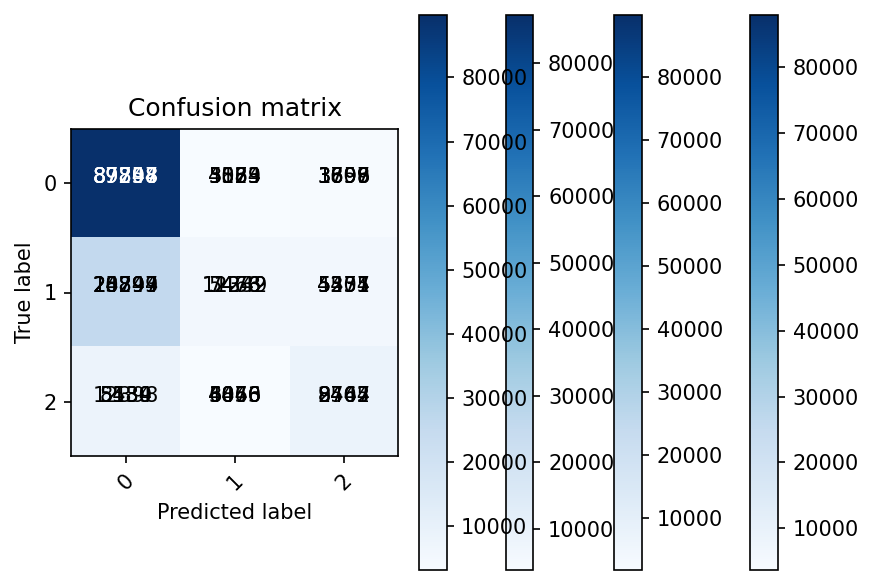

In [ ]:
for wavelet in waveletTypes:
    print('----------------',wavelet)
    X_train = train_window_data[wavelet]
    if len(X_train) > 0:
        X_test = test_window_data[wavelet]
        y_train = train_window_labels[wavelet]
        y_test = test_window_labels[wavelet]
        
        sc = StandardScaler()
        mm_sc = MinMaxScaler()
        sc.fit(X_train)
        X_train_sc = sc.transform(X_train)
        X_test_sc = sc.transform(X_test)

        mm_sc.fit(X_train)
        X_train_mm_sc = mm_sc.transform(X_train)
        X_test_mm_sc = mm_sc.transform(X_test)
        svm_clf = svm.SVC(kernel='linear',decision_function_shape = 'ovr',gamma='auto',random_state=0, C = 2.0,verbose=True)
        svm_clf.fit(X_train_mm_sc, y_train)
        print_score(svm_clf, X_train_mm_sc, y_train)

In [27]:
import numpy as np

def calculate_generalized_accuracy(confusion_matrix):
    # Ensure the confusion matrix is a NumPy array
    confusion_matrix = np.array(confusion_matrix)
    
    num_classes = confusion_matrix.shape[0]
    accuracies = []

    for i in range(num_classes):
        TP = confusion_matrix[i, i]
        FN = np.sum(confusion_matrix[i, :]) - TP
        FP = np.sum(confusion_matrix[:, i]) - TP
        TN = np.sum(confusion_matrix) - (TP + FN + FP)
        
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        accuracies.append(accuracy)
    
    average_accuracy = np.mean(accuracies)
    return average_accuracy

# Example usage
confusion_matrix = [[89748,  3174,  3657],
 [25793,  5463,  5474],
 [ 8180,  3456,  8405]]
average_accuracy = calculate_generalized_accuracy(confusion_matrix)
print(f"Average accuracy: {average_accuracy:.4f}")

Average accuracy: 0.7838


END